## Pneumonia detection by fine tuning ResNet-50 model

The following python cell would fix the random seeds, and import necessary modules. It also would make the notebook deterministic for reproducibility of results.

In [12]:
import os, random
import numpy as np
import torch

SEED = 27
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


## Loading the PneumoniaMNIST `.npz` Dataset

Here we point to your downloaded file, load it, and unpack into train/val/test images and labels.


In [ ]:
dataset_path = os.path.join("dataset", "pneumoniamnist.npz")

data = np.load(dataset_path)

train_images = data["train_images"]
train_labels = data["train_labels"]
val_images   = data["val_images"]
val_labels   = data["val_labels"]
test_images  = data["test_images"]
test_labels  = data["test_labels"]

print("Train:", train_images.shape, train_labels.shape)
print("Val:  ",  val_images.shape,   val_labels.shape)
print("Test: ", test_images.shape,  test_labels.shape)

Train: (3882, 28, 28) (3882, 1)
Val:   (524, 28, 28) (524, 1)
Test:  (624, 28, 28) (624, 1)


## Dataset Overview

Print each key, its shape, datatype—and peek at the first couple of entries for sanity checking.


In [14]:
print("Keys in data:", data.files)

for key in data.files:
    print(f"{key}: shape={data[key].shape}, dtype={data[key].dtype}")

for key in data.files:
    print(f"\nFirst 2 elements of {key}:\n", data[key][:2])

Keys in data: ['train_images', 'train_labels', 'val_images', 'val_labels', 'test_images', 'test_labels']
train_images: shape=(3882, 28, 28), dtype=uint8
train_labels: shape=(3882, 1), dtype=uint8
val_images: shape=(524, 28, 28), dtype=uint8
val_labels: shape=(524, 1), dtype=uint8
test_images: shape=(624, 28, 28), dtype=uint8
test_labels: shape=(624, 1), dtype=uint8

First 2 elements of train_images:
 [[[ 92 108 117 ...   5   8   6]
  [129 138 141 ...   4   2   3]
  [141 146 148 ...   0   0   0]
  ...
  [168 180 192 ... 119 115 126]
  [173 184 195 ... 153 139 132]
  [173 185 198 ... 168 154 139]]

 [[115 118 117 ... 123 115 104]
  [130 137 140 ... 146 135 121]
  [134 151 167 ... 152 138 123]
  ...
  [176 180 187 ... 169 151 142]
  [181 185 192 ... 173 163 158]
  [184 189 195 ... 183 176 169]]]

First 2 elements of train_labels:
 [[1]
 [1]]

First 2 elements of val_images:
 [[[ 88  81  87 ...  83  68  58]
  [ 96  94 105 ...  68  55  46]
  [107 101 110 ...  67  56  48]
  ...
  [161 159 16

## Quick Exploratory Data Analysis (EDA)

- Checking class balance in our train set  
- Visualizing some dataset images for knowledge

0 -> No Pneumonia -> 388
1 -> Pneumonia Presnt -> 3494


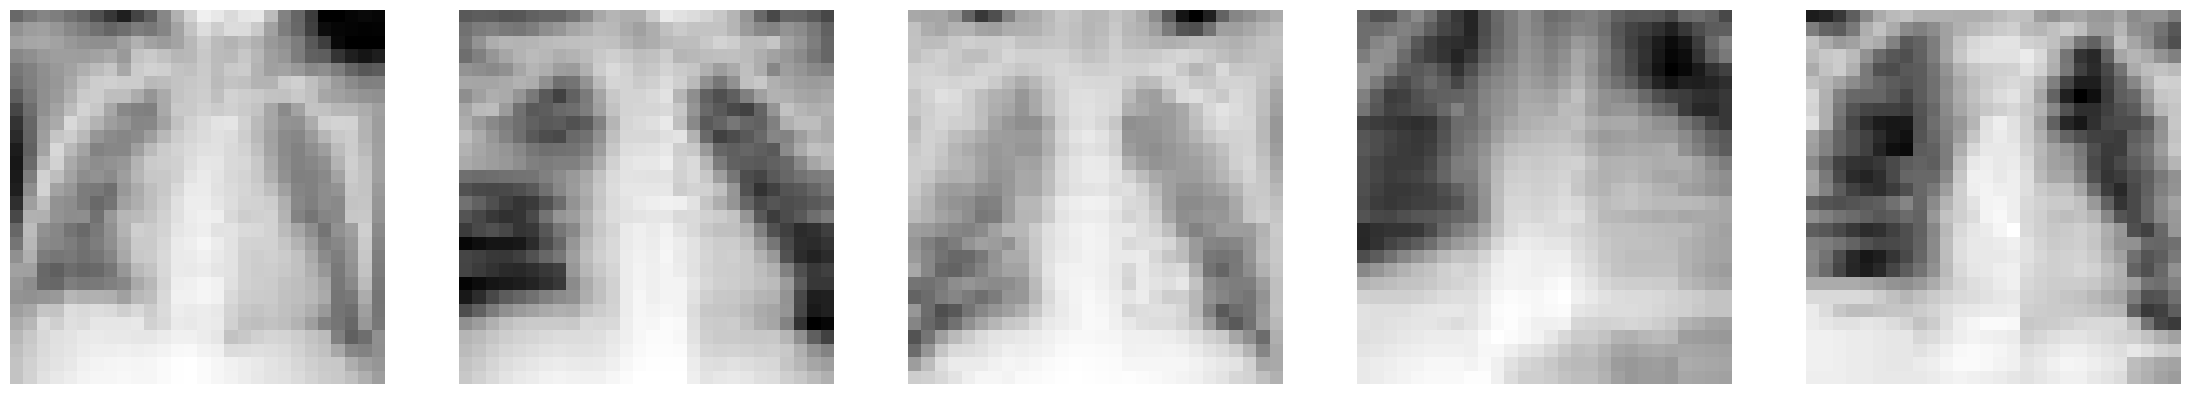

In [15]:
import matplotlib.pyplot as plt

# 1. Class balance with readable labels
label_names = {0: "No Pneumonia", 1: "Pneumonia Presnt"}
unique, counts = np.unique(train_labels, return_counts=True)
for label, count in zip(unique, counts):
    print(f"{label} -> {label_names.get(label, 'Unknown')} -> {count}")

# 2. Showing fist 5 train samples
fig, axes = plt.subplots(1, 5, figsize=(28, 28))
for ax, img in zip(axes, train_images[:5]):
    ax.imshow(img, cmap="gray")
    ax.axis("off")
plt.show()


## Prepare PyTorch Datasets & DataLoaders

Wraping up the NumPy arrays into a custom `Dataset` here, applying transforms, and setting up samplers to handle any imbalance.


In [16]:
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision import transforms

BATCH_SIZE = 32
IMAGE_SIZE = (224, 224) # found that 224x224 image size is necessary for RestNet-50
TRAIN_MEAN = [0.485, 0.456, 0.406] # normalization for RestNet-50
TRAIN_STD = [0.229, 0.224, 0.225] # normalization for RestNet-50
RANDOM_ROTATION_DEGREES = 10

# Transforms for training and validation datasets
train_tfms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Grayscale(num_output_channels=3), # Convert grayscale to 3-channel RGB as required by ResNet-50
    transforms.Resize(IMAGE_SIZE),
     transforms.RandomResizedCrop(224, scale=(0.85, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(RANDOM_ROTATION_DEGREES),
    transforms.ToTensor(),
    transforms.Normalize(TRAIN_MEAN, TRAIN_STD),
])
val_tfms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Grayscale(num_output_channels=3), # Convert grayscale to 3-channel RGB as required by ResNet-50
    transforms.Resize(IMAGE_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(TRAIN_MEAN, TRAIN_STD),
])

class PneumoDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels.flatten()         # shape (N,)
        self.tf     = transform
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, i):
        img = self.tf(self.images[i]) if self.tf else torch.tensor(self.images[i])
        return img, torch.tensor(int(self.labels[i]), dtype=torch.long)

# Instantiate datasets
train_ds = PneumoDataset(train_images, train_labels, train_tfms)
val_ds   = PneumoDataset(val_images,   val_labels,   val_tfms)
test_ds  = PneumoDataset(test_images,  test_labels,  val_tfms)

# Here i am fixing the class imbalance by using a `WeightedRandomSampler`.
# 1. Compute class counts & inverse weights
unique, counts = np.unique(train_labels, return_counts=True)
class_weights  = 1.0 / torch.tensor(counts, dtype=torch.float)

# 2. Turn labels into a LongTensor of indices
label_tensor   = torch.tensor(train_labels.flatten(), dtype=torch.long)

# 3. Index the weights by label to get per-sample weights
sample_weights = class_weights[label_tensor]

# 4. Create sampler & DataLoaders
sampler        = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)
train_loader   = DataLoader(train_ds, batch_size=BATCH_SIZE, sampler=sampler)
val_loader     = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False)
test_loader    = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False)

## Build the Transfer‐Learning Model

Load a pretrained ResNet‐50, freeze its backbone, and replace the final fully‐connected layer to output 2 classes for our penumonia classification.


In [ ]:
import torch.nn as nn
from torchvision.models import resnet50

# 1. Load pretrained backbone
model = resnet50(pretrained=True)

# 2. Freeze all backbone parameters for transfer learning
for param in model.parameters():
    param.requires_grad = False

# 3. Replace final layer for binary classification
in_features = model.fc.in_features
model.fc = nn.Sequential(
    nn.Linear(in_features, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            nn.Linear(512, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(256, 2)
)


model = model.to(device)
print(model)


c:\Users\singh\OneDrive\Documents\code\pneumonia-detection-gpu\venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\singh\OneDrive\Documents\code\pneumonia-detection-gpu\venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

## Set Up Training Loop

Define loss, optimizer (only updating the new head), LR scheduler, plus helper functions for one epoch of train & validation.


In [24]:
import torch.optim as optim
from sklearn.metrics import roc_auc_score

# Loss and optimizer (only head parameters)
criterion = nn.CrossEntropyLoss(label_smoothing=0.05)
optimizer = optim.Adam(model.fc.parameters(), lr=1e-4, weight_decay=1e-5)

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)

def train_one_epoch(loader):
    model.train()
    total_loss = 0.0
    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * images.size(0)
    return total_loss / len(loader.dataset)

def validate(loader):
    model.eval()
    all_probs, all_labels = [], []
    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            logits = model(images)
            probs = torch.softmax(logits, dim=1)[:,1].cpu().numpy()
            all_probs.extend(probs)
            all_labels.extend(labels.numpy())
    auc = roc_auc_score(all_labels, all_probs)
    
    # Step the scheduler here using validation AUC
    scheduler.step()
    print(f"→ Scheduler stepped with validation accuracy={auc:.4f} | Learning rate now: {optimizer.param_groups[0]['lr']:.6f}")
    
    return auc


## Train the Model with Early Stopping

Run up to 20 epochs, save the best checkpoint by validation AUC, and stop if no improvement for 5 epochs.


In [25]:
best_auc = 0.0
epochs_no_improve = 0
num_epochs = 20

for epoch in range(1, num_epochs+1):
    print(f"\nEpoch {epoch}/{num_epochs}")
    train_loss = train_one_epoch(train_loader)
    val_auc = validate(val_loader)
    scheduler.step()
    
    print(f"Epoch {epoch:02d} — Train Loss: {train_loss:.4f} — Validation accuracy: {val_auc:.4f}")
    
    # Check for improvement
    if val_auc > best_auc:
        best_auc = val_auc
        epochs_no_improve = 0
        torch.save(model.state_dict(), "best_resnet50.pth")
        print("  → New best model saved.")
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= 5:
            print("Early stopping triggered as no improvement made in last 5 epochs.")
            break



Epoch 1/20
→ Scheduler stepped with validation accuracy=0.9683 | Learning rate now: 0.000098
Epoch 01 — Train Loss: 0.2548 — Validation accuracy: 0.9683
  → New best model saved.

Epoch 2/20
→ Scheduler stepped with validation accuracy=0.9700 | Learning rate now: 0.000079
Epoch 02 — Train Loss: 0.2531 — Validation accuracy: 0.9700
  → New best model saved.

Epoch 3/20
→ Scheduler stepped with validation accuracy=0.9700 | Learning rate now: 0.000050
Epoch 03 — Train Loss: 0.2543 — Validation accuracy: 0.9700
  → New best model saved.

Epoch 4/20
→ Scheduler stepped with validation accuracy=0.9703 | Learning rate now: 0.000021
Epoch 04 — Train Loss: 0.2500 — Validation accuracy: 0.9703
  → New best model saved.

Epoch 5/20
→ Scheduler stepped with validation accuracy=0.9693 | Learning rate now: 0.000002
Epoch 05 — Train Loss: 0.2411 — Validation accuracy: 0.9693

Epoch 6/20
→ Scheduler stepped with validation accuracy=0.9708 | Learning rate now: 0.000002
Epoch 06 — Train Loss: 0.2422 — 

## Key Evaluation Metric: AUC-ROC

In the context of pneumonia detection, we're dealing with **medical diagnosis**, where the **cost of a false negative (missing pneumonia)** is much higher than a false positive.

### Why not just Accuracy?
Accuracy can be misleading in imbalanced datasets. For example:
- Predicting "normal" all the time could still give high accuracy if most patients are healthy.
- It doesn't reflect how confident or calibrated the model is.

### Best Metric: **AUC-ROC (Area Under the Receiver Operating Characteristic Curve)**

- AUC-ROC measures how well the model separates the two classes (pneumonia vs. normal) across all classification thresholds.
- It is **threshold-independent**, meaning it evaluates the model without choosing a hard cutoff like 0.5.
- AUC close to 1.0 means perfect classification; 0.5 means random guessing.

### Summary:
- Use **AUC-ROC** for evaluation.
- Use **Confusion Matrix, Precision, Recall, and F1-score** for supporting insight.


AUC-ROC Score: 0.9548


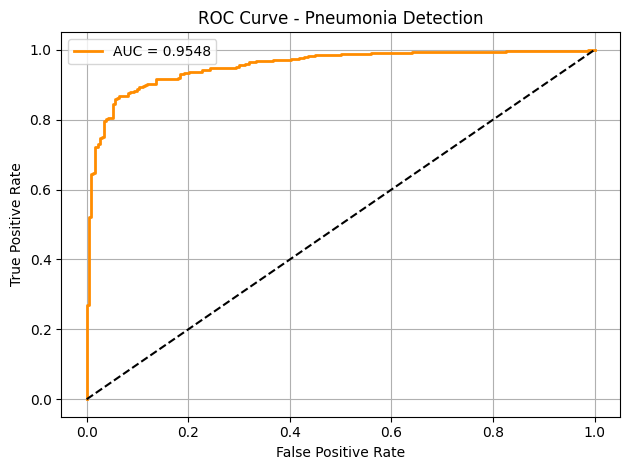


Classification Report:
              precision    recall  f1-score   support

      Normal       0.86      0.82      0.84       234
   Pneumonia       0.90      0.92      0.91       390

    accuracy                           0.88       624
   macro avg       0.88      0.87      0.87       624
weighted avg       0.88      0.88      0.88       624



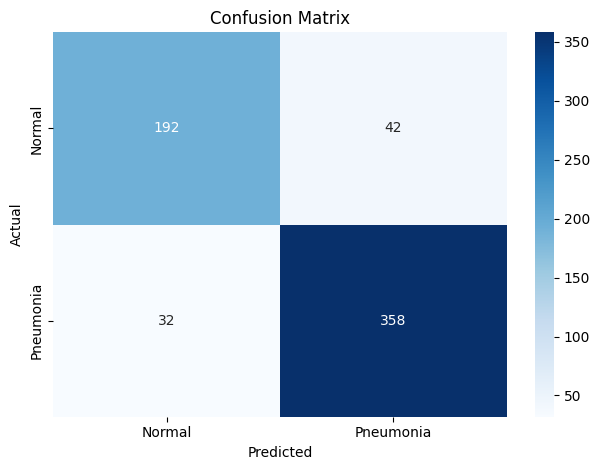

In [26]:

model.load_state_dict(torch.load("best_resnet50.pth"))
model.eval()

from sklearn.metrics import roc_auc_score, roc_curve, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

y_true, y_pred, y_scores = [], [], []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        logits = model(images)
        probs = torch.softmax(logits, dim=1)[:, 1].cpu().numpy()
        preds = np.argmax(logits.cpu().numpy(), axis=1)

        y_true.extend(labels.numpy())
        y_pred.extend(preds)
        y_scores.extend(probs)

# AUC
auc = roc_auc_score(y_true, y_scores)
print(f"AUC-ROC Score: {auc:.4f}")

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_true, y_scores)
plt.plot(fpr, tpr, label=f"AUC = {auc:.4f}", color="darkorange", linewidth=2)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Pneumonia Detection")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Classification Report & Confusion Matrix
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=["Normal", "Pneumonia"]))

cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Normal", "Pneumonia"], yticklabels=["Normal", "Pneumonia"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()
